# How To Run This Notebook

1. Run all cells until "Graphing Usage" section. 
2. Load data by calling `load_df(path)`, where `path` is filepath to csv file.
3. Get r_bg, r_np, data by calling `r_bg, r_np, df = cleanup(df)`.
4. Optionally remove outliers by calling `df = remove_outliers(df)`.
5. Graph results by calling `graph_firstRun(df, ["fg"])` where `["fg"]` can be replaced with any subset (e.g. `["bg", "np"]`) or omitted entirely (e.g. `graph_firstRun(df)`) to graph all three.

### Imports 

In [5]:
import random
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

In [6]:
# import csv 
# path = path to csv file
# reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
def load_df(path):
    df = pd.read_csv(path, header=None)
    return df

### Data Preprocessing Helper Functions 
(for datasets with schema (site, rank, r_time, r_time_eq, case, label, r_bg, r_np) only)

In [30]:
# makes new rows with clean values, e.g. 'rank=1' --> '1'
# reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
def row_cleanup(df):
    
    df['site'] = df[0].apply(lambda x: x[5:])
    df['rank'] = df[1].apply(lambda x: x[5:])
    df['r_time'] = df[2].apply(lambda x: x[7:])
    df['heavy_load_rtime'] = df[3].apply(lambda x: x[9:])
    df['html_parsing_time'] = df[4].apply(lambda x: x[11:])
    df['case'] = df[5].apply(lambda x: x[5:])
    df['label'] = df[6].apply(lambda x: x[6:])
    df['r_bg'] = df[7].apply(lambda x: x[5:])
    df['r_np'] = df[8].apply(lambda x: x[5:])
    
    return df

In [36]:
# drops unnecessary columns, converts to numeric, and gets rid of negatives 
# references:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
def col_cleanup(df):
    # drop cols
    df = df.drop(columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 'r_bg', 'r_np'])
    
    # convert string 'na' to None 
    df.loc[df['heavy_load_rtime'] == "na", "heavy_load_rtime"] = None
    df.loc[df['html_parsing_time'] == "na", "html_parsing_time"] = None
    
    # convert to numeric types
    df = df.astype({'rank':'int', 'r_time':'float', 'heavy_load_rtime':'float', 
                         'html_parsing_time':'float'})
    # get rid of negatives
    df['html_parsing_time'] = abs(df['html_parsing_time'])
    
    return df

In [31]:
# cleans up dataset and returns baseline vals and clean dataframe
# reference: https://pandas.pydata.org/docs/reference/api/pandas.unique.html
def cleanup(df):
    
    df = row_cleanup(df)
    r_bg = float(df['r_bg'].unique()[0])
    r_np = float(df['r_np'].unique()[0])
    df = col_cleanup(df)
    
    return r_bg, r_np, df

In [174]:
# removes outliers for a single label type
# e.g. of all bg r_times, remove outliers 
# references
# https://online.stat.psu.edu/stat200/lesson/3/3.2
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
def remove_outlier_with_label(df, label):
    
    label_df = df[df["label"] == label]
    Q1 = label_df.describe().iloc[4, 1]
    Q3 = label_df.describe().iloc[6, 1]
    IQR = Q3 - Q1

    df_filtered = label_df[label_df['r_time'] < (Q3 + 1.5*IQR)]
    df_filtered = df_filtered[df_filtered['r_time'] > (Q1 - 1.5*IQR)]
    return df_filtered

# removes outliers
def remove_outliers(df):
    
    labels = ["np", "bg", "fg"]
    filtered_dfs = []
    
    for label in labels:
        filtered_dfs.append(remove_outlier_with_label(df, label))
        
    return pd.concat(filtered_dfs)
    

In [75]:
# separates dataset into the separate cases
def get_cases(df):
    df_1 = df[df["case"] == "1"]
    df_2 = df[df["case"] == "2"]

    return df_1, df_2

### DELTA

In [216]:
# returns the delta thresholds using the empirical 68-95-99.7 rule
# inputs: dataframe, label (e.g. 'bg', 'np'), confidence level
# output: delta interval of form [lower_bound, upper_bound]
# references:
# https://en.wikipedia.org/wiki/68-95-99.7_rule
def get_delta(df, label, interval=3):
    
    # remove outliers
    df = remove_outliers(df)
    
    # get interval
    df = df[df['label'] == label]
    mean = df['r_time'].mean()
    print(mean)
    sd = df['r_time'].std()
    print(sd)
    
    interval = [mean - interval*sd, mean + interval*sd]
    return interval

In [225]:
# Calculates bg vs np accuracy using delta
# references:
    # https://pandas.pydata.org/docs/reference/api/pandas.concat.html
    
def bg_np_acc(df, include_outliers = True):
    
    # depending on include_outliers, np_df and bg_df will or will not include outliers
    if include_outliers == False:
        new_df = remove_outliers(df)
        np_df = new_df[new_df['label'] == 'np']
        bg_df = new_df[new_df['label'] == 'bg']
    else:
        np_df = df[df['label'] == 'np']
        bg_df = df[df['label'] == 'bg']
        
    # count number of np outside interval
    np_interval = get_delta(df, 'np')
    np_err = len(pd.concat([np_df[np_df['r_time'] < np_interval[0]], np_df[np_df['r_time'] > np_interval[1]]]).index)
    
    # count number of bg outside interval
    bg_interval = get_delta(df, 'bg')
    bg_err = len(pd.concat([bg_df[bg_df['r_time'] < bg_interval[0]], bg_df[bg_df['r_time'] > bg_interval[1]]]).index)
    
    total_rows = len(np_df.index) + len(bg_df.index)
    acc = (total_rows - np_err - bg_err) / total_rows
    print(f"NP vs BG Accuracy: {acc}")
    

### Get data for SVM: 
    Case 1: fg (1) vs bg (0) --> measure heavy load rtime
    Case 2: fg (1) vs np (0) --> measure html loading time

In [83]:
# removes bg and makes a binary label column 
def get_svm_df(df, case):
    
    if case == "1":
        df_svm = df[df["label"] != 'np']
        
    elif case == "2":
        df_svm = df[df["label"] != 'bg']
    
    else: 
        print("Error: invalid case")
        return None

    svm_label = (df_svm['label'] == 'fg')
    df_svm['svm_label'] = svm_label
    df_svm = df_svm.astype({'svm_label':'int'})
    
    # for each site rank for fg sites: 
    # if fg r_time does not overlap with np/bg confidence intervals, remove that rank for fg and np 
    # outliers are removed --> indices may not match perfectly 
    return df_svm

In [84]:
# returns training and testing splits
# reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html
def get_splits(df, x1, x2):
    X_pd = pd.DataFrame()
    X_pd[x1] = df[x1]
    X_pd[x2] = df[x2]
    X = X_pd.to_numpy()
    y = df['svm_label'].to_numpy()
    
    # get training and testing sets
    # 80% train, 20% test
    size = len(df)
    
    split_idx = (size // 5) * 4
    indices = [i for i in range(size)]
    random.shuffle(indices)
    X_train = X[indices[:split_idx]]
    y_train = y[indices[:split_idx]]
    X_test = X[indices[split_idx:size]]
    y_test = y[indices[split_idx:size]]
    
    return X_train, y_train, X_test, y_test
    

In [90]:
def get_svm_splits(df, case):
    
    df_svm = get_svm_df(df, case)
    if case == "1":
        X_train, y_train, X_test, y_test = get_splits(df_svm, 'r_time', 'heavy_load_rtime')
    elif case == "2":
        X_train, y_train, X_test, y_test = get_splits(df_svm, 'r_time', 'html_parsing_time')
    else:
        return None
    
    return X_train, y_train, X_test, y_test

### Make SVM

In [86]:
# given a dataframe containing either case1 data or case2 data, and the case number,
# trains and tests a SVM model 
# returns the trained SVM model 
def get_svm(df, case):
    # get train and test splits
    X_train, y_train, X_test, y_test = get_svm_splits(df, case)
    print("Shapes: ")
    print(f"X_train:{X_train.shape}, y_train:{y_train.shape}, X_test:{X_test.shape}, y_test:{y_test.shape}")
    
    # make classifier
    # reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    svm = SVC(kernel='linear', random_state=0)
    svm.fit(X_train, y_train)

    train_pred = svm.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print('Training Accuracy:', "{:.3f}".format(train_acc))

    test_pred = svm.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print('Testing Accuracy:', "{:.3f}".format(test_acc))
    
    return svm

### Graphs

In [210]:
# Graphs rank vs. r_time for ALL datapoints in the dataset that have the labels specified.
# Can optionally show the confidence intervals (delta), which will be calculated without outliers 
# inputs: 
    # df: full dataframe 
    # types: list of types to graph, e.g. ["fg"], ["bg", "fg"]. Order does not matter, but don't use duplicates.
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
    # title: title of graph
    # confidence: whether to show confidence intervals (only valid if types contains both "bg" and/or "np")
def graph_firstRun(df, types=[], height=15, width=4, title="", delta=False, show_outliers=True):
    
    # sets height and width
    # reference: https://www.statology.org/seaborn-figure-size/
    sns.set(rc={"figure.figsize":(height, width)}) 
    
    display_df = df
    if show_outliers == False:
        display_df = remove_outliers(df)
        
    # take subset if needed
    if len(types) != 0:
        new_df = pd.DataFrame()
        for ele in types:
            subset = display_df[display_df['label'] == ele]
            new_df = pd.concat([new_df, subset])
        display_df = new_df 
        
    # graph
    # references: 
    # https://seaborn.pydata.org/generated/seaborn.scatterplot.html
    # https://www.statology.org/seaborn-axis-labels/
    # https://www.geeksforgeeks.org/how-to-change-axes-limits-in-seaborn/
    ax = sns.scatterplot(data=display_df, x='r_time', y='rank', hue='label', hue_order=['bg', 'fg', 'np'])
    ax.set(xlabel='Relative Loading Time',
           ylabel='Site Rank',
           title=title)
    xlim_top = max(df['r_time']+0.1)
    ax.set_xlim(0, xlim_top)
    
    # show delta intervals if needed
    # references: 
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html
    # https://www.statology.org/seaborn-add-line-to-scatterplot/
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linestyle
    if delta:
        if "bg" in types or len(types) == 0:
            bg_interval = get_delta(df, 'bg')
            print("bg interval: " + str(bg_interval))
            plt.axvline(bg_interval[0], color='blue', linestyle='--')
            plt.axvline(bg_interval[1], color='blue', linestyle='--')

        if "np" in types or len(types) == 0:
            np_interval = get_delta(df, 'np')
            print("np_interval: " + str(np_interval))
            plt.axvline(np_interval[0], color='green', linestyle='--')
            plt.axvline(np_interval[1], color='green', linestyle='--')
        ax.set_xlim(0, max(xlim_top, bg_interval[1]+0.1, np_interval[1]+0.1))        
    


In [109]:
# graphs r_time vs. heavy_loading_rtime
# inputs: 
    # df: dataframe 
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
def graph_secondRun(df, case, height=15, width=4, xlim=(0, 0.8), ylim=(-0.0001, 0.0016), svm=None):
    
    # sets height and width
    sns.set(rc={"figure.figsize":(height, width)}) 
    if case == "1":
        df = df[df["label"] != 'np']
        # graph
        ax = sns.scatterplot(data=df, x='r_time', y='heavy_load_rtime', hue='label')
        ax.set(xlabel='Relative Loading Time',
               ylabel='Relative Loading Time Under CPU Pressure',
               title="Case 1: Relative Loading Time vs Relative Loading Time Under CPU Pressure")
        ax.set_xlim(xlim[0], xlim[1])
        
    elif case == "2":
        df = df[df["label"] != 'bg']
        ax = sns.scatterplot(data=df, x='r_time', y='html_parsing_time', hue='label')
        ax.set(xlabel='Relative Loading Time',
               ylabel='HTML Parsing Time',
               title="Case 2: Relative Loading Time vs HTML Parsing Time")
        ax.set_xlim(xlim[0], xlim[1])
    
    # graph svm decision boundary
    if svm != None:
        # decision boundary has equation a1x1 + a2x2 + b = 0
        # references:
        # https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
        # https://seaborn.pydata.org/generated/seaborn.lineplot.html
        a = svm.coef_[0]           
        b = svm.intercept_[0]      
        x_points = np.linspace(xlim[0], xlim[1])    
        y_points = - (a[0]/a[1])*x_points - (b/a[1])
        sns.lineplot(x=x_points, y=y_points)
        ax.set_ylim(ylim[0], ylim[1])
        

In [88]:
# graphs r_time vs. html_parsing
# inputs: 
    # df: dataframe 
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
def graph_case2(df, case=2, height=15, width=4, xlim=(0, 0.8), ylim=(-0.0001, 0.0016), svm=None):
    
    # sets height and width
    sns.set(rc={"figure.figsize":(height, width)}) 
    df = df[df["label"] != 'bg']
    
    # graph
    ax = sns.scatterplot(data=df, x='r_time', y='html_parsing_time', hue='label')
    ax.set(xlabel='Relative Loading Time',
           ylabel='HTML Parsing Time',
           title="Case 2: Relative Loading Time vs HTML Parsing Time")
    ax.set_xlim(xlim[0], xlim[1])
    
    # graph svm decision boundary
    if svm != None:
        # decision boundary has equation a1x1 + a2x2 + b = 0
        # references:
        # https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
        # https://seaborn.pydata.org/generated/seaborn.lineplot.html
        a = svm.coef_[0]           
        b = svm.intercept_[0]      
        x_points = np.linspace(xlim[0], xlim[1])    
        y_points = - (a[0]/a[1])*x_points - (b/a[1])
        sns.lineplot(x=x_points, y=y_points)
        ax.set_ylim(ylim[0], ylim[1])
        

## Top 50 sites

In [219]:
# load df
original_df = load_df('results/all_top_50_2.csv')

In [220]:
original_df

,0,1,2,3,4,5,6,7,8
0,site=google.com,rank=1,r_time=0.08374870016049107,r_time_1=na,r_time_eq2=0.0005534028125249158,case=2,label=np,r_bg=0.6435199056585005,r_np=0.6978521546458866
1,site=www.google.com,rank=2,r_time=0.07853422010737328,r_time_1=na,r_time_eq2=0.00012498532877396553,case=2,label=np,r_bg=0.6435199056585005,r_np=0.6978521546458866
2,site=microsoft.com,rank=3,r_time=0.08047657347295951,r_time_1=na,r_time_eq2=0,case=2,label=np,r_bg=0.6435199056585005,r_np=0.6978521546458866
3,site=data.microsoft.com,rank=4,r_time=0.07728145664438345,r_time_1=na,r_time_eq2=0.00012476556129236414,case=2,label=np,r_bg=0.6435199056585005,r_np=0.6978521546458866
4,site=events.data.microsoft.com,rank=5,r_time=0.07722848357270383,r_time_1=na,r_time_eq2=0.0001309066595330698,case=2,label=np,r_bg=0.6435199056585005,r_np=0.6978521546458866
...,...,...,...,...,...,...,...,...,...
195,site=nrdp-ipv6.prod.ftl.netflix.com,rank=46,r_time=0.30350675008608885,r_time_1=0.45269912281750596,r_time_eq2=na,case=1,label=fg,r_bg=0.6435199056585005,r_np=0.6978521546458866
196,site=outlook.office365.com,rank=47,r_time=0.16634972980753748,r_time_1=0.3542533175960139,r_time_eq2=na,case=1,label=fg,r_bg=0.6435199056585005,r_np=0.6978521546458866
197,site=fonts.googleapis.com,rank=48,r_time=0.3139825428065307,r_time_1=0.548526177091734,r_time_eq2=na,case=1,label=fg,r_bg=0.6435199056585005,r_np=0.6978521546458866
198,site=teams.microsoft.com,rank=49,r_time=0.20792428619366057,r_time_1=0.4476063341944602,r_time_eq2=na,case=1,label=fg,r_bg=0.6435199056585005,r_np=0.6978521546458866


In [221]:
# get r_bg, r_np, and clean dataset
r_bg, r_np, df = cleanup(original_df)
print(r_bg)
print(r_np)
df

0.6435199056585005
0.6978521546458866


,site,rank,r_time,heavy_load_rtime,html_parsing_time,case,label
0,google.com,1,0.083749,NaN,0.000553,2,np
1,www.google.com,2,0.078534,NaN,0.000125,2,np
2,microsoft.com,3,0.080477,NaN,0.000000,2,np
3,data.microsoft.com,4,0.077281,NaN,0.000125,2,np
4,events.data.microsoft.com,5,0.077228,NaN,0.000131,2,np
...,...,...,...,...,...,...,...
195,nrdp-ipv6.prod.ftl.netflix.com,46,0.303507,0.452699,NaN,1,fg
196,outlook.office365.com,47,0.166350,0.354253,NaN,1,fg
197,fonts.googleapis.com,48,0.313983,0.548526,NaN,1,fg
198,teams.microsoft.com,49,0.207924,0.447606,NaN,1,fg


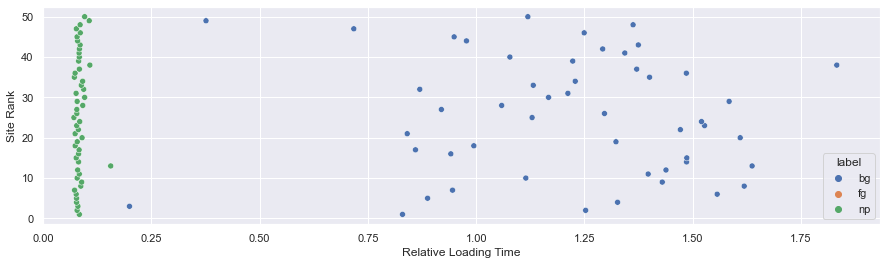

In [222]:
graph_firstRun(df, ["bg", "np"])

1.2296978796548972
0.2876342336851426
bg interval: [0.3667951785994693, 2.092600580710325]
0.08177463720044614
0.0061271947339717825
np_interval: [0.06339305299853079, 0.1001562214023615]


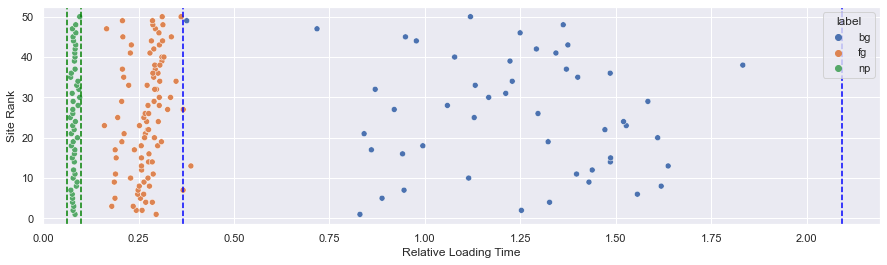

In [223]:
graph_firstRun(df, delta=True, show_outliers=False)

1.2296978796548972
0.2876342336851426
bg interval: [0.3667951785994693, 2.092600580710325]
0.08177463720044614
0.0061271947339717825
np_interval: [0.06339305299853079, 0.1001562214023615]


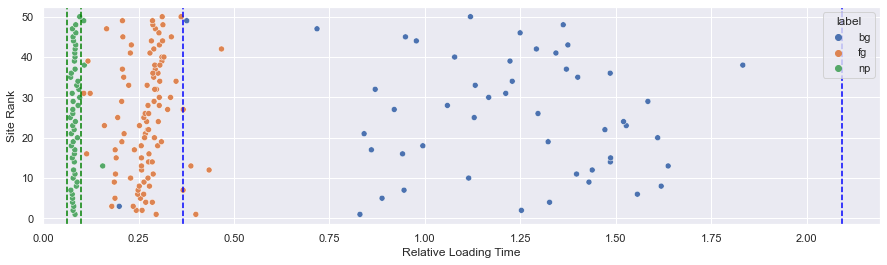

In [229]:
graph_firstRun(df, delta=True, show_outliers=True)

In [227]:
bg_np_acc(df, include_outliers=True)

0.08177463720044614
0.0061271947339717825
1.2296978796548972
0.2876342336851426
NP vs BG Accuracy: 0.96


In [228]:
bg_np_acc(df, include_outliers=False)

0.08177463720044614
0.0061271947339717825
1.2296978796548972
0.2876342336851426
NP vs BG Accuracy: 1.0


In [76]:
case1, case2 = get_cases(df)

In [77]:
case1

,site,rank,r_time,heavy_load_rtime,html_parsing_time,case,label
100,google.com,1,0.519606,1.299228,NaN,1,bg
101,www.google.com,2,0.738067,1.412317,NaN,1,bg
102,microsoft.com,3,0.612922,0.709431,NaN,1,bg
103,data.microsoft.com,4,0.765289,0.788070,NaN,1,bg
104,events.data.microsoft.com,5,0.643858,1.344802,NaN,1,bg
...,...,...,...,...,...,...,...
195,nrdp-ipv6.prod.ftl.netflix.com,46,0.295246,0.620562,NaN,1,fg
196,outlook.office365.com,47,0.209802,0.382981,NaN,1,fg
197,fonts.googleapis.com,48,0.313233,0.586351,NaN,1,fg
198,teams.microsoft.com,49,0.231157,0.587942,NaN,1,fg


In [78]:
case2

,site,rank,r_time,heavy_load_rtime,html_parsing_time,case,label
0,google.com,1,0.066643,NaN,0.000608,2,np
1,www.google.com,2,0.060045,NaN,0.000143,2,np
2,microsoft.com,3,0.060622,NaN,0.000000,2,np
3,data.microsoft.com,4,0.061904,NaN,0.000127,2,np
4,events.data.microsoft.com,5,0.046751,NaN,0.000000,2,np
...,...,...,...,...,...,...,...
95,nrdp-ipv6.prod.ftl.netflix.com,46,0.302273,NaN,0.000000,2,fg
96,outlook.office365.com,47,0.133230,NaN,0.000000,2,fg
97,fonts.googleapis.com,48,0.351613,NaN,0.000091,2,fg
98,teams.microsoft.com,49,0.308695,NaN,0.000081,2,fg


In [91]:
svm1 = get_svm(case1, "1")

Shapes: 
X_train:(72, 2), y_train:(72,), X_test:(22, 2), y_test:(22,)
Training Accuracy: 0.903
Testing Accuracy: 0.818


In [92]:
svm2 = get_svm(case2, "2")

Shapes: 
X_train:(80, 2), y_train:(80,), X_test:(20, 2), y_test:(20,)
Training Accuracy: 0.963
Testing Accuracy: 0.950


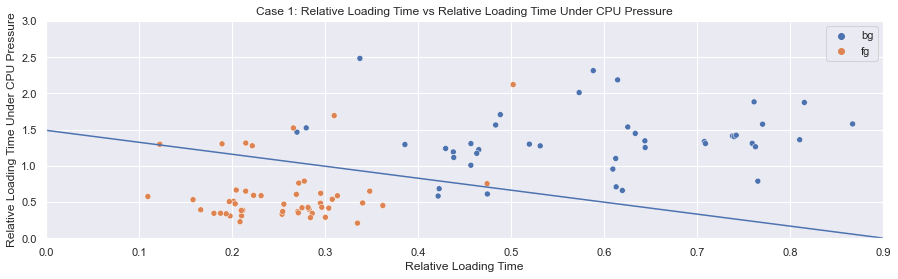

In [113]:
graph_secondRun(df=case1, case="1", svm=svm1, xlim=(0, 0.9), ylim=(-0.0001, 3.0016))

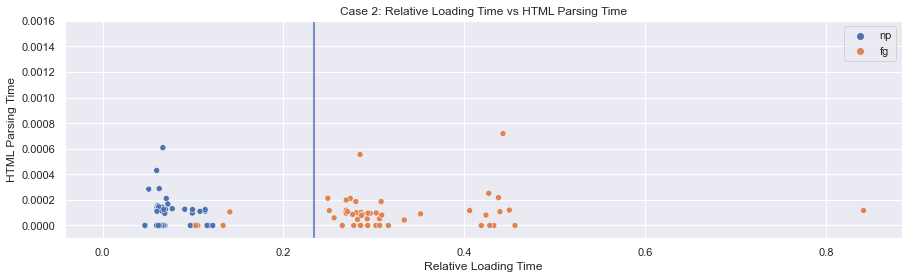

In [105]:
graph_secondRun(case2, "2", svm=svm2)

### Trying Different Datasets

In [194]:
# try Sihan's fg/bg and Mingzhi's np
fg = pd.read_csv('browser-security-sv1/results/frontend.csv', header=None)
bg = pd.read_csv('browser-security-sv1/results/backend.csv', header=None)
np = pd.read_csv('browser-security-sv1/results/np.csv', header=None)

fg['label'] = "fg"
bg['label'] = "bg"
np['label'] = "np"
fg

,0,1,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
295,296,0.016870,fg
296,297,0.008169,fg
297,298,0.019919,fg
298,299,0.066070,fg


In [172]:
sep_df = pd.concat([fg, bg, np])
sep_df

,0,1,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np
298,299,0.146430,np


In [173]:
sep_df = sep_df.rename(columns={1:'r_time', 0:'rank'})
sep_df

,rank,r_time,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np
298,299,0.146430,np


In [174]:
sep_dropped_df = sep_df[:899]
sep_dropped_df

,rank,r_time,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
294,295,0.111054,np
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np


<Axes: xlabel='r_time', ylabel='rank'>

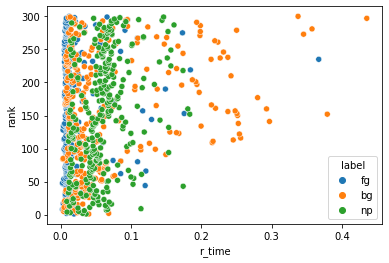

In [176]:
sns.scatterplot(data=sep_dropped_df, x='r_time', y='rank', hue='label')

In [178]:
sep_df_no_fg = pd.concat([bg, np]).rename(columns={1:'r_time', 0:'rank'})
sep_df_no_fg

,rank,r_time,label
0,1,0.040102,bg
1,2,0.068421,bg
2,3,0.023694,bg
3,4,0.026622,bg
4,5,0.004452,bg
...,...,...,...
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np
298,299,0.146430,np


<Axes: xlabel='r_time', ylabel='rank'>

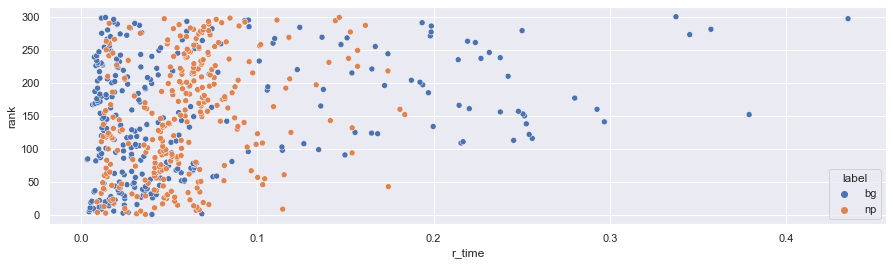

In [201]:
sns.set(rc={"figure.figsize":(15, 4)}) #width=3, #height=4
sep_df_no_fg = sep_df_no_fg[:599]
sns.scatterplot(data=sep_df_no_fg, x='r_time', y='rank', hue='label')